# Installing Requirements

Activate a Python environment and install the following
```
pip install pandas
pip install numpy
pip install darts
pip install matplotlib
pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
pip install ipykernel
pip install --upgrade nbformat
pip install lightgbm xgboost
pip install seaborn
pip install distributed
pip install datasetsforecast
pip install matplotlib
pip install yfinance
# for the changes to apply you might need to restart your ide or python notebook after installing the following
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension
```

In [321]:
''' 
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install matplotlib
!pip install yfinance
# you might need to restart your ide or python notebook after installing the following
# for the changes to apply
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension
'''

' \n!pip install pandas\n!pip install numpy\n!pip install darts\n!pip install matplotlib\n!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"\n!pip install ipykernel\n!pip install --upgrade nbformat\n!pip install lightgbm xgboost\n!pip install seaborn\n!pip install distributed\n!pip install datasetsforecast\n!pip install matplotlib\n!pip install yfinance\n# you might need to restart your ide or python notebook after installing the following\n# for the changes to apply\n!pip install --upgrade jupyter ipywidgets\n!jupyter nbextension enable --py widgetsnbextension\n'

In [322]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


First, let's import a few things:

In [323]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


# Load crypto close price data from Yahoo Finance

Specify the list of cryptos for which you want to forecast prices

In [324]:
crypto_list = ['BTC', 'ETH', 'DOT', 'MATIC', 'SOL']

Download from Yahoo Finance the close prices over time for the specified cryptos

In [325]:
from datetime import datetime

today_date = datetime.today().date()

data = pd.DataFrame()
for crypto in crypto_list: 
    all_price_data = yf.download(f'{crypto}-USD', interval = '1d', period='10y')
    if crypto == 'BTC':
        data.index = all_price_data.index
        # add missing dates in index
        idx_dates = list(pd.date_range(min(data.index), today_date))
        data = data.reindex(idx_dates, None)

    data[f'{crypto}'] = all_price_data['Close']

data.tail()

[*********************100%***********************]  1 of 1 completed


/var/folders/rn/j1t3lrd938bf8zng2m3h5nlh0000gn/T/ipykernel_81220/1762341223.py:12: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.
  data = data.reindex(idx_dates, None)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC,ETH,DOT,MATIC,SOL
Date,,,,,
2023-07-08,30292.541016,1865.539551,5.126468,0.680288,21.859268
2023-07-09,30171.234375,1863.009766,5.079419,0.688225,21.349005
2023-07-10,30414.470703,1880.556396,5.135243,0.736487,21.313776
2023-07-11,30620.951172,1878.336060,5.211542,0.742122,22.092934
2023-07-12,30779.125000,1895.056152,5.248341,0.742091,22.606789


Forward fill missing values

In [326]:
data = data.fillna(method="ffill")
data.tail()

,BTC,ETH,DOT,MATIC,SOL
Date,,,,,
2023-07-08,30292.541016,1865.539551,5.126468,0.680288,21.859268
2023-07-09,30171.234375,1863.009766,5.079419,0.688225,21.349005
2023-07-10,30414.470703,1880.556396,5.135243,0.736487,21.313776
2023-07-11,30620.951172,1878.336060,5.211542,0.742122,22.092934
2023-07-12,30779.125000,1895.056152,5.248341,0.742091,22.606789


Drop today's date for which we don't have yet the close price yet

In [327]:
data = data.loc[data.index!=str(today_date)]
data = data.fillna(0)

# Plot data

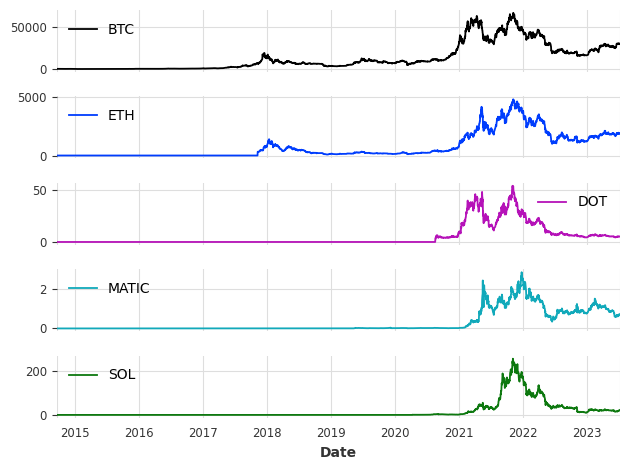

In [328]:
data.plot(subplots=True)

plt.tight_layout()
plt.show()

## Convert dataframe to darts timeseries

In [329]:
from darts import TimeSeries
data = data.reset_index()
series = TimeSeries.from_dataframe(data, time_col="Date", value_cols=crypto_list)

## Create a training and validation series

For what follows, we will split our `TimeSeries` into a training and a validation series. 

The training series will be a `TimeSeries` containing values until 1 week ago, and the validation series a `TimeSeries` containing the rest:

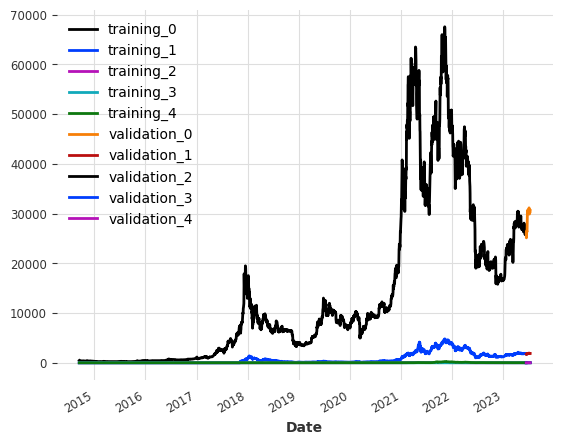

In [330]:
from datetime import datetime, timedelta

val_set_size = 28
val_set_split_date = max(data["Date"])-timedelta(days=val_set_size)
train, val = series.split_before(val_set_split_date)
train.plot(label="training")
val.plot(label="validation")

# Scale data

Let's scale these series between 0 and 1, as that will benefit most ML models. We will use a [Scaler](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html) for this:

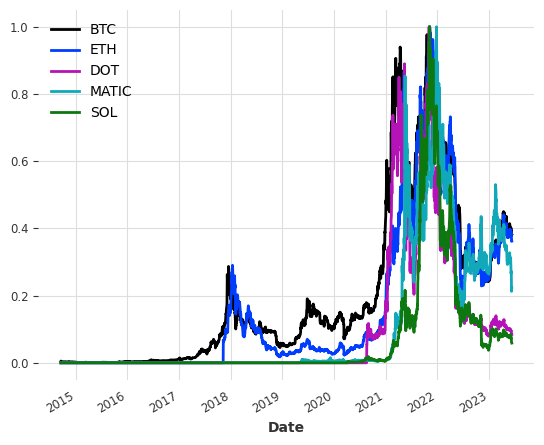

In [331]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
scaler = scaler.fit(train)
train_scaled = scaler.transform(train)
train_scaled = train_scaled.astype("float32")
val_scaled = scaler.transform(val)
val_scaled = val_scaled.astype("float32")
train_scaled.plot()

# Inspect Seasonality
It seems quite obvious that the data has a long term cyclical pattern, but let's use the auto-correlation function (ACF) to investigate if there is weekly or monthly seasonality in the BTC close price.

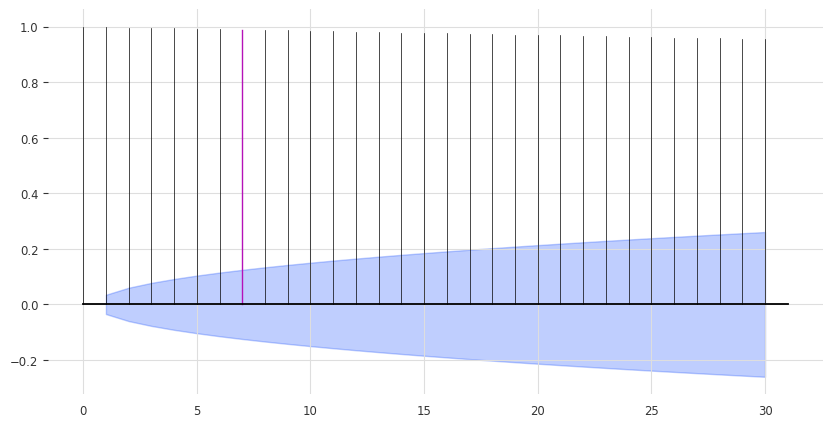

In [332]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_scaled["BTC"], m=7, alpha=0.05, max_lag=30)

We don't observe any weekly seasonality

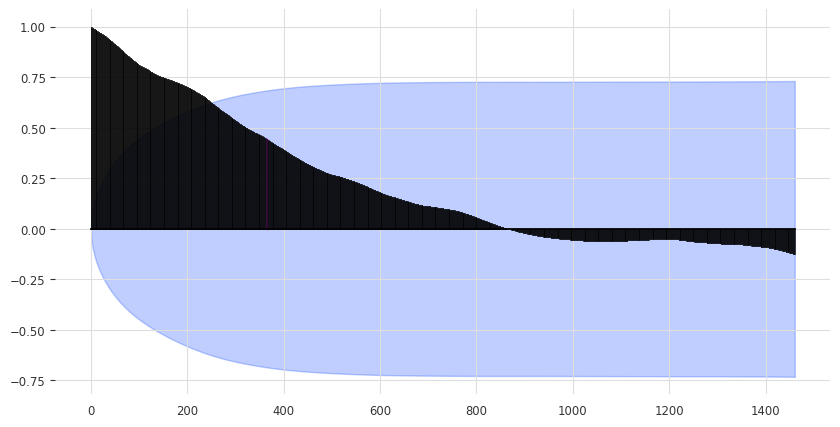

In [333]:
plot_acf(train_scaled["BTC"], m=365, alpha=0.05, max_lag=4*365)

We can observe a weak 6 month seasonality and a long term cyclical pattern that might be related to the Bitcoin halving that occurs every 4 years

The blue zone determines the significance of the statistics for a confidence level of $\alpha = 5\%$. We can also run a statistical check of seasonality for each candidate period `m`:

In [334]:
for m in range(2, 8*365):
    is_seasonal, period = check_seasonality(train_scaled["BTC"], m=m, alpha=0.05, max_lag=8*365)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

The BTC close price does not seem to have any seasonal pattern with significance of the statistics for a confidence level of $\alpha = 5\%$

# Machine learning and global models
Darts has a rich support for machine learning and deep learning forecasting models; for instance:

* [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) can wrap around any sklearn-compatible regression model to produce forecasts (it has its own [section below](#Regression-forecasting-models)).
* [RNNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html) is a flexible RNN implementation, which can be used like DeepAR.
* [NBEATSModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html) implements the N-BEATS model.
* [TFTModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html) implements the Temporal Fusion Transformer model.
* [TCNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) implements temporal convolutional networks.
* ...

In addition to supporting the same basic `fit()`/`predict()` interface as the other models, these models are also *global models*, as they support being trained on multiple time series (sometimes referred to as *meta learning*). 

This is a key point of using ML-based models for forecasting: more often than not, ML models (especially deep learning models) need to be trained on large amounts of data, which often means a large amount of separate yet related time series. 

In Darts, the basic way to specify multiple `TimeSeries` is using a `Sequence` of `TimeSeries` (for instance, a simple list of `TimeSeries`).



## Using deep learning: example with N-BEATS
Next, we will build an [N-BEATS model](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html). This model can be tuned with many hyper-parameters (such as number of stacks, layers, etc). Here, for simplicity, we will use it with default hyper-parameters. The only two hyper-parameters that we have to provide are:

* `input_chunk_length`: this is the "lookback window" of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.
* `output_chunk_length`: this is the "forward window" of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

The `random_state` parameter is just here to get reproducible results.

Most neural networks in Darts require these two parameters. Here, we will use multiples of the seasonality. We are now ready to fit our model on our two series (by giving a list containing the two series to `fit()`):

Note how we can scale several series in one go. We can also parallelize this sort of operations over multiple processors by specifying `n_jobs`.

In [335]:
from darts.models import NBEATSModel

input_chunk_length = 6*30
output_chunk_length = len(val)
NBEATSModel_model = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, random_state=42)

NBEATSModel_model.fit(train_scaled, epochs=20, verbose=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/evagian/.pyenv/versions/3.9.16/envs/timeseries_forecasting_with_covariates/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 13.1 M
---------------------------------------------------
13.1 M    Trainable params
6.7 K     Non-trainable params
13.1 M    Total params
52.425    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=180, output_chunk_length=29, random_state=42)

Let's now get some forecasts 7 days ahead, for our cytpo price series. We can just use the `series` argument of the `fit()` function to tell the model which series to forecast. Importantly, the `output_chunk_length` does not directly constrain the forecast horizon `n` that can be used with `predict()`. Here, we trained the model with `output_chunk_length=len(val)` and produce forecasts for `n=len(val)` days ahead; this is simply done in an auto-regressive way behind the scenes (where the network recursively consumes its previous outputs).

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

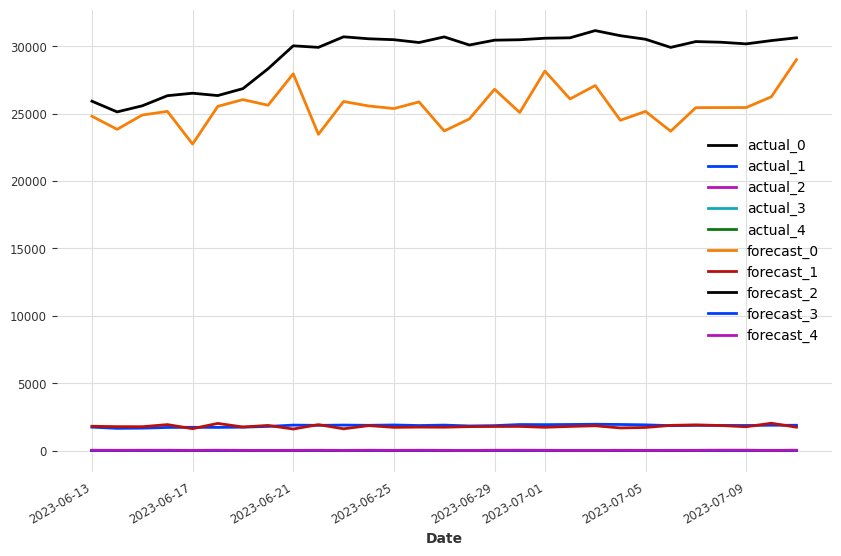

In [336]:
NBEATSModel_pred_scaled = NBEATSModel_model.predict(series=train_scaled, n=len(val))

# scale back:
NBEATSModel_pred = scaler.inverse_transform(NBEATSModel_pred_scaled)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
NBEATSModel_pred.plot(label="forecast")

Plot the scaled BTC actual and forecasted close price values

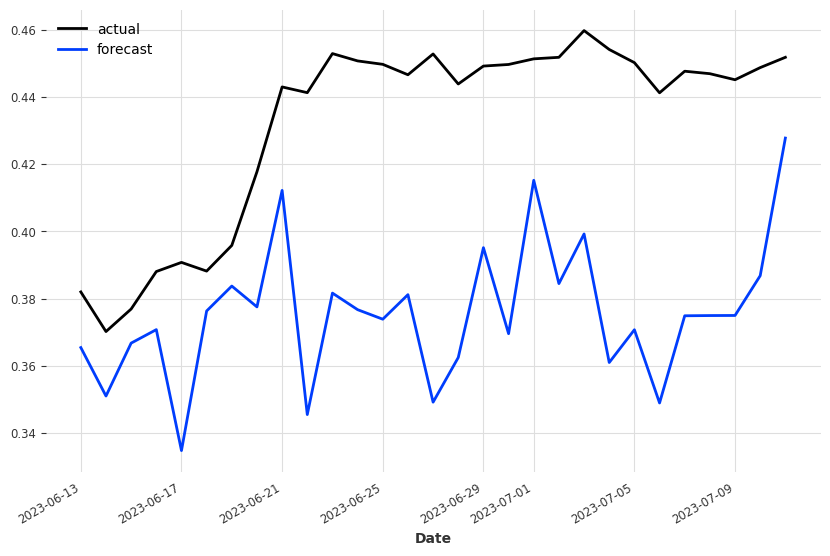

In [337]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
NBEATSModel_pred_scaled["BTC"].plot(label="forecast")

At a first glance, the forecast does not look good. We have high map and high forecasted price deviations.

However, if we look carefully in the first forecasted week, we will see that the model nicely forecasts whether the price will go up or down. This model can be proven useful for day traders. When trading, it it more important to know whether the price will increase or reduce in the following day than the actual close price value.

# Create evaluation metrics dictionary

This dictionary will hold the name of the model and the model accuracy metrics.

At the end we will use it to select the best performing model.

In [338]:
from darts.metrics import mape, mse, smape

accuracy_metrics_dict = { }
accuracy_metrics_dict["NBEATSModel no covs"] = { }

Note how we obtained the forecasts for all time series at once above. Similarly, we can also get the accuracy metrics for all crypto price timeseries

In [339]:
mape(NBEATSModel_pred, val)

18.13694652030573

In [340]:
accuracy_metrics_dict["NBEATSModel no covs"]["mse"] = mse(NBEATSModel_pred, val)
accuracy_metrics_dict["NBEATSModel no covs"]["mape"] = mape(NBEATSModel_pred, val)
accuracy_metrics_dict["NBEATSModel no covs"]["smape"] = smape(NBEATSModel_pred, val)
accuracy_metrics_dict

{'NBEATSModel no covs': {'mse': 3643713.5804385156,
  'mape': 18.13694652030573,
  'smape': 18.141183550022046}}

# Covariates: using external data
In addition to the **target** series (the series we are interested to forecast), many models in Darts also accept **covariates** series in input. Covariates are series that we do not want to forecast, but which can provide helpful additional information to the models. Both the targets and covariates can be multivariate or univariate.

There are two kinds of covariate time series in Darts:

* `past_covariates` are series not necessarily known ahead of the forecast time. Those can for instance represent things that have to be measured and are not known upfront. Models do not use the future values of `past_covariates` when making forecasts. 

* `future_covariates` are series which are known in advance, up to the forecast horizon. This can represent things such as calendar information, holidays, weather forecasts, etc. Models that accept `future_covariates` will look at the future values (up to the forecast horizon) when making forecasts.

![covariates](https://unit8co.github.io/darts/_images/covariates-highlevel.png)


Each covariate can potentially be multivariate. If you have several covariate series (such as month and year values), you should `stack()` or `concatenate()` them to obtain a multivariate series.

The covariates you provide can be longer than necessary. Darts will try to be smart and slice them in the right way for forecasting the target, based on the time indexes of the different series. You will receive an error if your covariates do not have a sufficient time span, though.

In the cells below, we use the `darts.utils.timeseries_generation.datetime_attribute_timeseries()` function to generate series containing the month and year values, and we `concatenate()` these series along the `"component"` axis in order to obtain one covariate series with two components (month and year), per target series. For simplicity, we directly scale the month and year values to have them between (roughly) 0 and 1:

# Future & Past covariates

In our case we will use: 

* The Fear & Greed index as `past_covariates`
* The Days Until Halving as `future_covariates`

# Get Fear & Greed Index Data ([Source](https://www.cointree.com/learn/crypto-fear-and-greed-index/))

The Crypto Fear and Greed Index uses social signals and market trends to determine the overall sentiment of the crypto market, based on btcereum and other large cryptocurrencies. It’s called an index because it takes multiple data sources and combines them into a single figure.

The index is divided into the following four categories: 

- 0-24: Extreme fear (orange)
- 25-49: Fear (amber/yellow)
- 50-74: Greed (light green)
- 75-100: Extreme greed (green)

In [341]:
import requests
import itertools
fear_greed_data_url = "https://api.alternative.me/fng/?limit=0&format=json&date_format=cn"  
# sending get request and saving the response as response object
fear_greed_data_request = requests.get(url = fear_greed_data_url)
fear_greed_data = fear_greed_data_request.json()
# create a dataframe with the fear and greed index value per day
fear_greed_data_df = pd.DataFrame(fear_greed_data["data"])
# convert timestamp to datetime
fear_greed_data_df["timestamp"] = pd.to_datetime(fear_greed_data_df["timestamp"])
# set timestamp as the dataframe row index
fear_greed_data_df = fear_greed_data_df.set_index("timestamp")
# add missing date indices
idx_dates = list(pd.date_range(min(fear_greed_data_df.index), max(fear_greed_data_df.index)))
fear_greed_data_df = fear_greed_data_df.reindex(idx_dates, None)
# forward fill missing values
fear_greed_data_df["value"] = fear_greed_data_df["value"].fillna(method="ffill")
# drop todays date for which we don't have the final fear and greed index value
fear_greed_data_df = fear_greed_data_df.loc[fear_greed_data_df.index!=str(today_date)]
fear_greed_data_df.tail()

/var/folders/rn/j1t3lrd938bf8zng2m3h5nlh0000gn/T/ipykernel_81220/3840698127.py:15: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.
  fear_greed_data_df = fear_greed_data_df.reindex(idx_dates, None)


,value,value_classification,time_until_update
timestamp,,,
2023-07-07,55,Greed,NaN
2023-07-08,58,Greed,NaN
2023-07-09,55,Greed,NaN
2023-07-10,56,Greed,NaN
2023-07-11,57,Greed,NaN


Create a Darts timeseries from the Fear & Greed Index dataframe values

In [342]:
fear_and_greed_series = TimeSeries.from_times_and_values(fear_greed_data_df.index, fear_greed_data_df["value"])

# Calculate days until next Bitcoin halving

![alternatvie text](https://content-hub-static.crypto.com/static/6851d4d3e7092bad0d573d72576f2660/c9af3/Research_Bitcoin-Halving_effect_on_price_infographic.jpg)

## What Is Bitcoin Halving? ([source](https://www.forbes.com/advisor/au/investing/cryptocurrency/bitcoin-halving/#:~:text=Bitcoin%20halving%20is%20when%20the,counteract%20inflation%20by%20maintaining%20scarcity.))
Bitcoin halving is when the reward for bitcoin mining is cut in half, and takes place every four years.

The halving policy was written into bitcoin’s mining algorithm to counteract inflation by maintaining scarcity.

## How often does a halving occur?
For every 210,000 blocks, the number of newly issued bitcoins is cut in half. This translates to roughly every four years, depending on how quickly blocks are mined, which averages about 10 minutes. 

## Does the Halving Affect Bitcoin’s (and consecutively rest of crypto) Price? ([source](https://crypto.com/university/what-is-bitcoin-halving))
BTC price can be affected by the halving as:

* Rewards are halved, which promotes healthy and sustainable growth of the network. By reducing the rate at which new bitcoins are generated, the halving ensures that Bitcoin’s supply remains limited and finite, which can help maintain its value over time.
* The inflation rate of Bitcoin decreases after a halving, meaning the supply of new coins entering the market is reduced.

This topic is often debated amongst market analysts and participants alike. Some believe the halving will cause a significant increase in the price of Bitcoin, as the reduced inflation rate will lead to higher demand and a corresponding increase in value. Others argue that the halving is already priced into the market, and the event will have no effect on the price of the cryptocurrency.

In [343]:
halvings_dict = {1:"2012-11-28", 2:"2016-09-09", 3:"2020-05-11", 4:"2024-04-27"}
halving_cols=[]
# create a column with the date difference in days between the row Date and the next halving dates 
for key in halvings_dict:
    # add a column for each one of the halving dates, with the date of the halving as values
    data[f'halving_{key}_date'] = pd.to_datetime(halvings_dict[key]).date() 
    # calculate the difference in days between the row Date and each one of the halving dates
    diff = (pd.to_datetime(data.Date) - pd.to_datetime(data[f'halving_{key}_date'])).dt.days 
    # for each halding date, create a column the date difference value
    data[f'days_since_halving_{key}'] = diff
    # remove negative date differences because they refer to halving dates before the index dates
    data[f'days_since_halving_{key}'] = np.where(data[f'days_since_halving_{key}']<0, None, data[f'days_since_halving_{key}'])
    data = data.drop(columns=[f'halving_{key}_date'])
    # create a list with the columns names holding the number of days between the index date and each halving
    halving_cols.append(f'days_since_halving_{key}')

# keep the minimun value of all the positive halving date differences
# this difference refers to the first halving date after the index Date
data["days_since_last_halving"] = data[halving_cols].min(axis=1)
data = data.drop(columns=halving_cols)
data.head()

,Date,BTC,ETH,DOT,MATIC,SOL,days_since_last_halving
0,2014-09-17,457.334015,0.0,0.0,0.0,0.0,658.0
1,2014-09-18,424.440002,0.0,0.0,0.0,0.0,659.0
2,2014-09-19,394.795990,0.0,0.0,0.0,0.0,660.0
3,2014-09-20,408.903992,0.0,0.0,0.0,0.0,661.0
4,2014-09-21,398.821014,0.0,0.0,0.0,0.0,662.0


In [344]:
from darts import TimeSeries
data = data.set_index("Date")
days_until_halving_series = TimeSeries.from_times_and_values(data.index, data["days_since_last_halving"])

In [345]:
print(f"We have Fear & Greed index values since {min(fear_greed_data_df.index.date)}")

We have Fear & Greed index values since 2018-02-01


Drop crypto price data for dates before the minimum Fear & Greed index value date

In [346]:
_, series = series.split_before(min(fear_greed_data_df.index))
_, train = train.split_before(min(fear_greed_data_df.index))
_, train_scaled = train_scaled.split_before(min(fear_greed_data_df.index))
_, days_until_halving_series = days_until_halving_series.split_before(min(fear_greed_data_df.index))

# Define past covariates

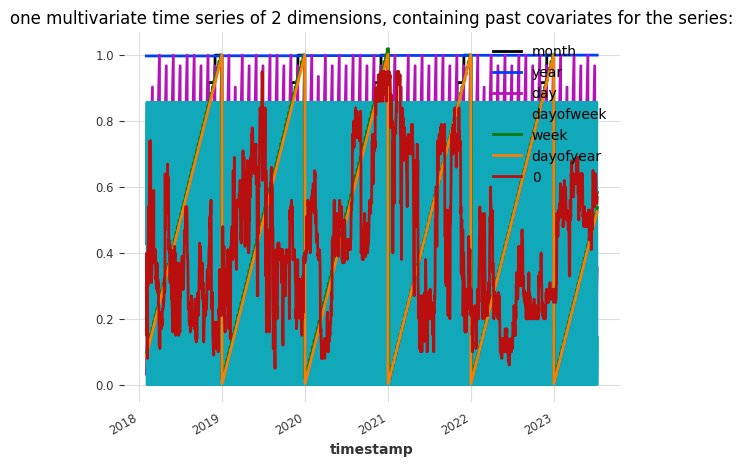

In [347]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

past_covs = concatenate(
    [
        dt_attr(fear_and_greed_series.time_index, "month", dtype=np.float32) / 12,
        dt_attr(fear_and_greed_series.time_index, "year", dtype=np.float32) / max(train.time_index.year),
        dt_attr(fear_and_greed_series.time_index, "day", dtype=np.float32) / 31,
        dt_attr(fear_and_greed_series.time_index, "dayofweek", dtype=np.float32) / 7,
        dt_attr(fear_and_greed_series.time_index, "week", dtype=np.float32) / 52,
        dt_attr(fear_and_greed_series.time_index, "dayofyear", dtype=np.float32) / 365,
        fear_and_greed_series / 100,
    ],
    axis="component",
)


past_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing past covariates for the series:"
);

# Define future covariates

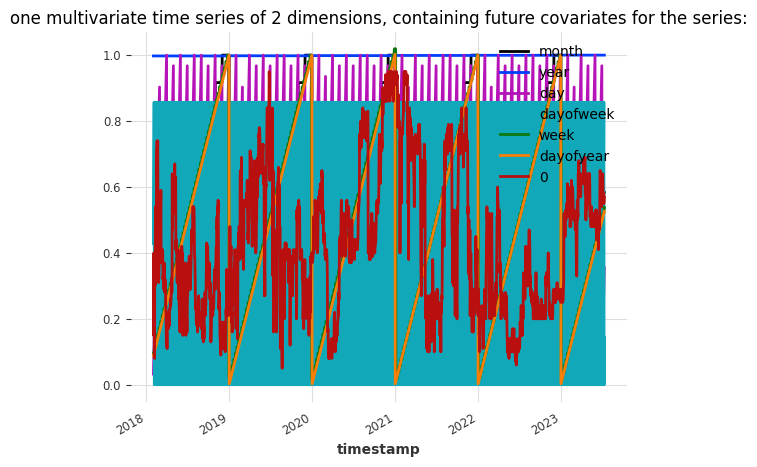

In [348]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

future_covs = concatenate(
    [
        dt_attr(fear_and_greed_series.time_index, "month", dtype=np.float32) / 12,
        dt_attr(fear_and_greed_series.time_index, "year", dtype=np.float32) / max(train.time_index.year),
        dt_attr(fear_and_greed_series.time_index, "day", dtype=np.float32) / 31,
        dt_attr(fear_and_greed_series.time_index, "dayofweek", dtype=np.float32) / 7,
        dt_attr(fear_and_greed_series.time_index, "week", dtype=np.float32) / 52,
        dt_attr(fear_and_greed_series.time_index, "dayofyear", dtype=np.float32) / 365,
        days_until_halving_series / 1000
    ],
    axis="component",
)


past_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing future covariates for the series:"
);

Not all models support all types of covariates. `NBEATSModel` supports only `past_covariates`. Therefore, even though our covariates represent calendar information and are known in advance, we will use them as `past_covariates` with N-BEATS. To train, all we have to do is give them as `past_covariates` to the `fit()` function, in the same order as the targets:

In [349]:
from darts.dataprocessing.transformers import Scaler

NBEATSModel_model_with_cov = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, random_state=42)
train_scaled = train_scaled.astype("float32")
val_scaled = val_scaled.astype("float32")
input_chunk_length
NBEATSModel_model_with_cov.fit(
    train_scaled,
    past_covariates=past_covs.astype("float32"),
    epochs=5,
    verbose=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/evagian/.pyenv/versions/3.9.16/envs/timeseries_forecasting_with_covariates/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 23.0 M
---------------------------------------------------
23.0 M    Trainable params
14.2 K    Non-trainable params
23.0 M    Total params
92.185    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=180, output_chunk_length=29, random_state=42)

Then to produce forecasts, we again have to provide our covariates as `past_covariates` to the `predict()` function. Even though the covariates time series also contains "future" values of the covariates up to the forecast horizon, the model will *not* consume those future values, because it uses them as past covariates (and not future covariates).

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


env: PYTORCH_ENABLE_MPS_FALLBACK=1


Predicting: 0it [00:00, ?it/s]

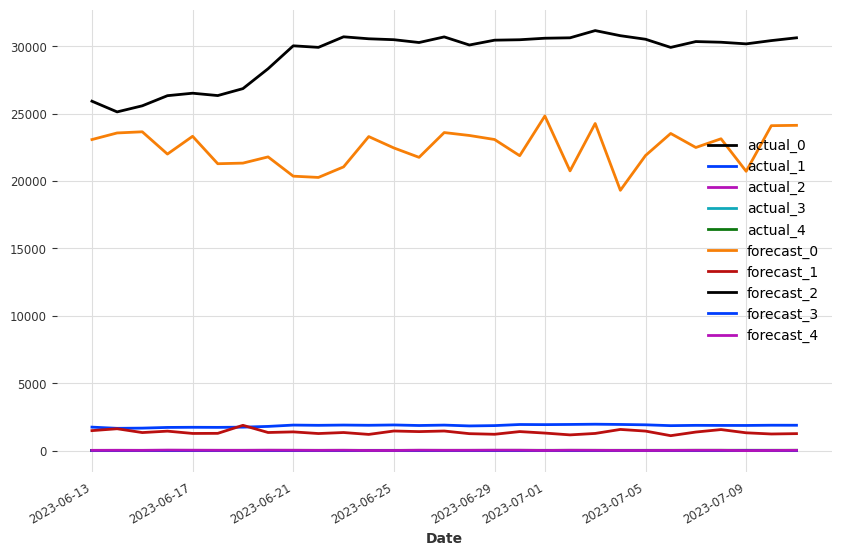

In [350]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

NBEATSModel_model_with_cov_pred_scaled = NBEATSModel_model_with_cov.predict(series=train_scaled, past_covariates=past_covs.astype("float32"), n=len(val))

# scale back:
NBEATSModel_model_with_cov_pred = scaler.inverse_transform(NBEATSModel_model_with_cov_pred_scaled)
plt.figure(figsize=(10, 6))
val.plot(label="actual")
NBEATSModel_model_with_cov_pred.plot(label="forecast")

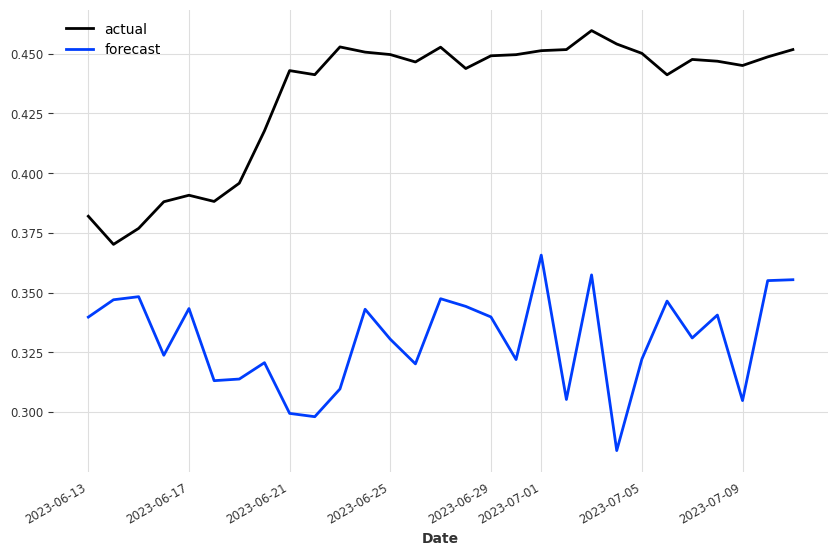

In [351]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
NBEATSModel_model_with_cov_pred_scaled["BTC"].plot(label="forecast")

In [352]:
accuracy_metrics_dict["NBEATSModel with covs"] = { }
accuracy_metrics_dict["NBEATSModel with covs"]["mse"] = mse(NBEATSModel_model_with_cov_pred, val)
accuracy_metrics_dict["NBEATSModel with covs"]["mape"]  = mape(NBEATSModel_model_with_cov_pred, val)
accuracy_metrics_dict["NBEATSModel with covs"]["smape"] = smape(NBEATSModel_model_with_cov_pred, val)

# Regression forecasting models

[RegressionModel's](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) are forecasting models which wrap around sklearn-compatible regression models. The inner regression model is used to predict future values of the target series, as a function of certain lags of the target, past and future covariates. Behind the scenes, the time series are tabularized in order to build a training dataset in the right format. 

By default, the `RegressionModel` will do a linear regression. It is very easy to use any desired sklearn-compatible regression model by specifying the `model` parameter, but for convenience Darts also provides a couple of ready-made models out of the box:

* [RandomForest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html) wraps around `sklearn.ensemble.RandomForestRegressor`.
* [LightGBMModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html) wraps around `lightbm`.
* [LinearRegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html) wraps around `sklearn.linear_model.LinearRegression` (accepting the same kwargs).

For example, this is what fitting a Bayesian ridge regression to our toy two-series problem looks like:

# BayesianRidge

By the way: similarly to transformers such as `Scaler`, computing metrics can be parallelized over `N` processors when executed over many series pairs by specifying `n_jobs=N`.

In [353]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

lags = 3*30
RidgeRegressionModel_model = RegressionModel(lags=lags, lags_future_covariates=[-6, 0], model=BayesianRidge())

RidgeRegressionModel_model.fit(
    train_scaled, future_covariates=future_covs.astype("float32")
)

RegressionModel(lags=90, lags_past_covariates=None, lags_future_covariates=[-6, 0], output_chunk_length=1, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

Several things happened above:

* `lags` is telling the `RegressionModel` to look at the past n lags of the target.
* In addition, `lags_future_covariates=[-6, 0]` means that the model will also look at lags of the `future_covariates` we provide. Here we enumerate the precise lags we want the models to take into account; the "-6th" and the "0th" lags. The "0th" lag means the "current" lag (i.e., at the time step being forecasted); obviously, knowning this lag requires knowing the data in advance (hence the fact we are using `future_covariates`). Similarly, `-6` means we also look at the value of the covariates 6 months before the forecasted time step (which also requires to know the covariates in advance if we are forecasting at a horizon more than 6 steps ahead).
* `model=BayesianRidge()` provides the actual inner regression model.

Now let's get some forecasts:

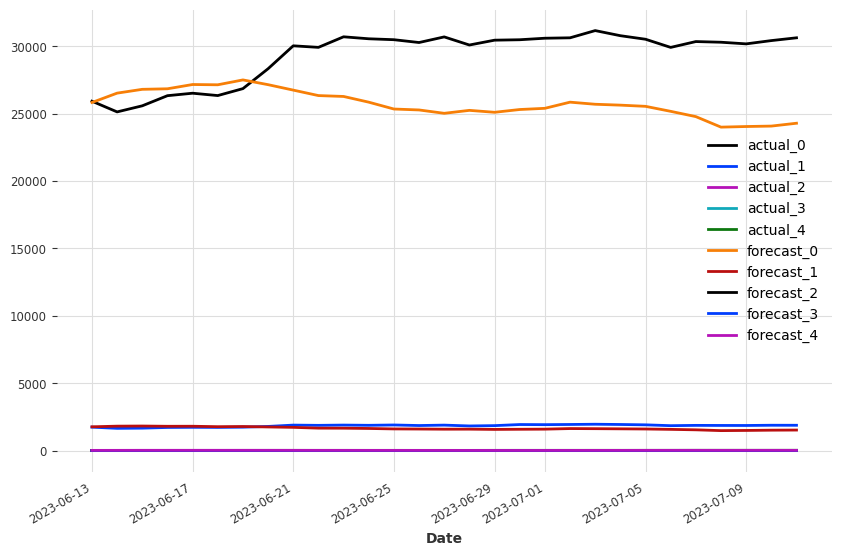

In [354]:
RidgeRegressionModel_pred_scaled = RidgeRegressionModel_model.predict(
    series=train_scaled,
    future_covariates=future_covs.astype("float32"),
    n=len(val),
)

# scale back:
RidgeRegressionModel_pred = scaler.inverse_transform(RidgeRegressionModel_pred_scaled)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
RidgeRegressionModel_pred.plot(label="forecast")


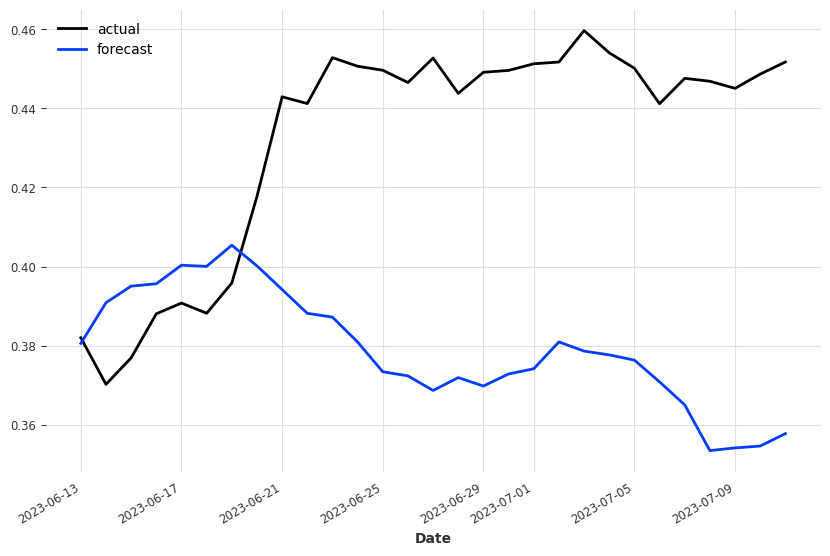

In [355]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
RidgeRegressionModel_pred_scaled["BTC"].plot(label="forecast")

In [356]:
accuracy_metrics_dict["BayesianRidge with covs"] = { }
accuracy_metrics_dict["BayesianRidge with covs"]["mse"] = mse(RidgeRegressionModel_pred, val)
accuracy_metrics_dict["BayesianRidge with covs"]["mape"] = mape(RidgeRegressionModel_pred, val)
accuracy_metrics_dict["BayesianRidge with covs"]["smape"] = smape(RidgeRegressionModel_pred, val)
accuracy_metrics_dict

{'NBEATSModel no covs': {'mse': 3643713.5804385156,
  'mape': 18.13694652030573,
  'smape': 18.141183550022046},
 'NBEATSModel with covs': {'mse': 10706150.302725244,
  'mape': 41.71088653861199,
  'smape': 28.827726366082857},
 'BayesianRidge with covs': {'mse': 3989469.8507875428,
  'mape': 18.287356301460285,
  'smape': 18.043553886020575}}

It seems that the BayesianRidge model performs better, how does it do when we backval it on this one series?

We will backval in the latest 20% of the timeseries and set the forecast horizon to 7. 

  0%|          | 0/387 [00:00<?, ?it/s]

MAPE = 30.08


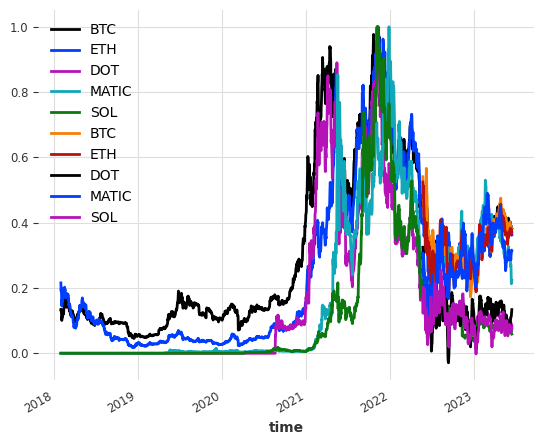

In [357]:
bayes_ridge_model_backval = RegressionModel(
    lags=lags, lags_future_covariates=[0], model=BayesianRidge()
)

backval = bayes_ridge_model_backval.historical_forecasts(
    train_scaled, 
    future_covariates=future_covs.astype("float32"), 
    start=0.8, 
    forecast_horizon=7, 
    verbose=True,
    retrain=True
)

print("MAPE = %.2f" % (mape(backval, train_scaled )))
train_scaled.plot()
backval.plot()

# LightGBM

In [358]:
from lightgbm import LGBMRegressor

lags = 30
LGBMRegressor_model = RegressionModel(lags=lags, lags_future_covariates=[-6, 0], model=LGBMRegressor())

LGBMRegressor_model.fit(
    train_scaled, future_covariates=future_covs.astype("float32")
)

RegressionModel(lags=30, lags_past_covariates=None, lags_future_covariates=[-6, 0], output_chunk_length=1, add_encoders=None, model=LGBMRegressor(), multi_models=True, use_static_covariates=True)

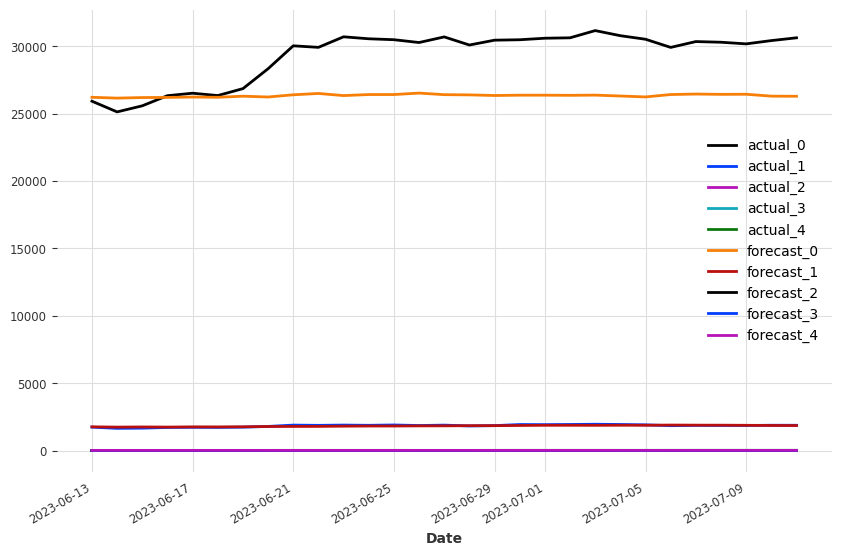

In [359]:
LGBMRegressor_pred_scaled = LGBMRegressor_model.predict(
    series=train_scaled,
    future_covariates=future_covs.astype("float32"),
    n=len(val),
)

# scale back:
LGBMRegressor_pred = scaler.inverse_transform(LGBMRegressor_pred_scaled)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
LGBMRegressor_pred.plot(label="forecast")


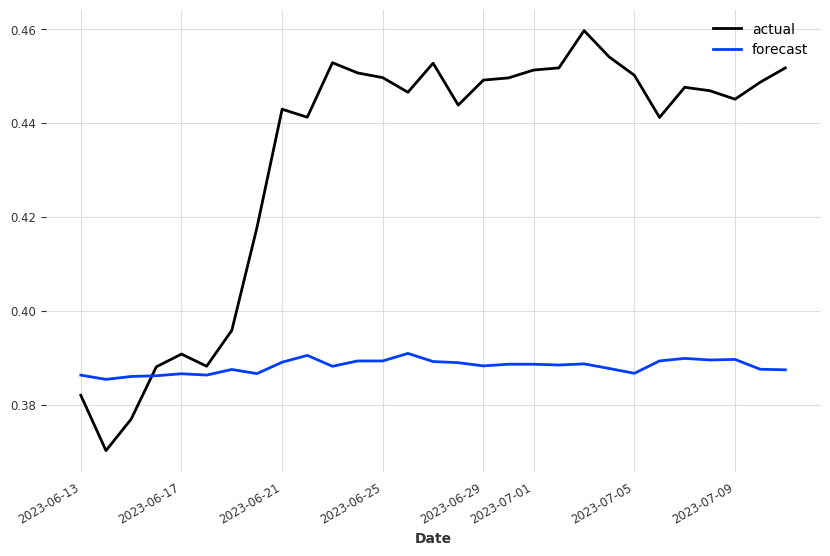

In [360]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
LGBMRegressor_pred_scaled["BTC"].plot(label="forecast")

In [361]:
accuracy_metrics_dict["LGBMRegressor with covs"] = { }
accuracy_metrics_dict["LGBMRegressor with covs"]["mse"] = mse(LGBMRegressor_pred, val)
accuracy_metrics_dict["LGBMRegressor with covs"]["mape"] = mape(LGBMRegressor_pred, val)
accuracy_metrics_dict["LGBMRegressor with covs"]["smape"] = smape(LGBMRegressor_pred, val)
accuracy_metrics_dict

{'NBEATSModel no covs': {'mse': 3643713.5804385156,
  'mape': 18.13694652030573,
  'smape': 18.141183550022046},
 'NBEATSModel with covs': {'mse': 10706150.302725244,
  'mape': 41.71088653861199,
  'smape': 28.827726366082857},
 'BayesianRidge with covs': {'mse': 3989469.8507875428,
  'mape': 18.287356301460285,
  'smape': 18.043553886020575},
 'LGBMRegressor with covs': {'mse': 2436176.0297599994,
  'mape': 12.31065925161899,
  'smape': 11.042207133417346}}

# BayesianRidge is better

# XGBoost Regression

In [362]:
from xgboost.sklearn import XGBRegressor

lags = 3*30
XGBRegressor_model = RegressionModel(lags=lags, lags_future_covariates=[-6, 0], model=XGBRegressor())

XGBRegressor_model.fit(
    train_scaled, future_covariates=future_covs.astype("float32")
)

RegressionModel(lags=90, lags_past_covariates=None, lags_future_covariates=[-6, 0], output_chunk_length=1, add_encoders=None, model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), multi_models=True, use_static_covariates=True)

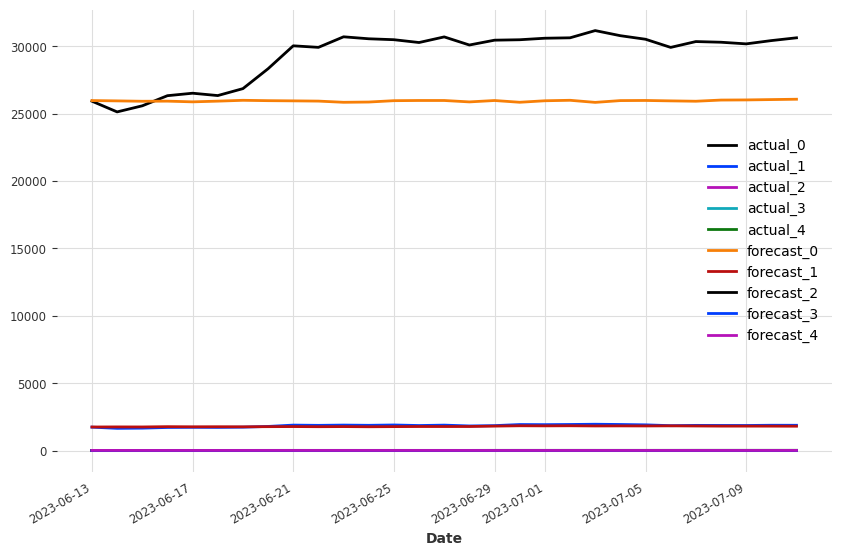

In [363]:
XGBRegressor_pred_scaled = XGBRegressor_model.predict(
    series=train_scaled,
    future_covariates=future_covs.astype("float32"),
    n=len(val),
)

# scale back:
XGBRegressor_pred = scaler.inverse_transform(XGBRegressor_pred_scaled)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
XGBRegressor_pred.plot(label="forecast")


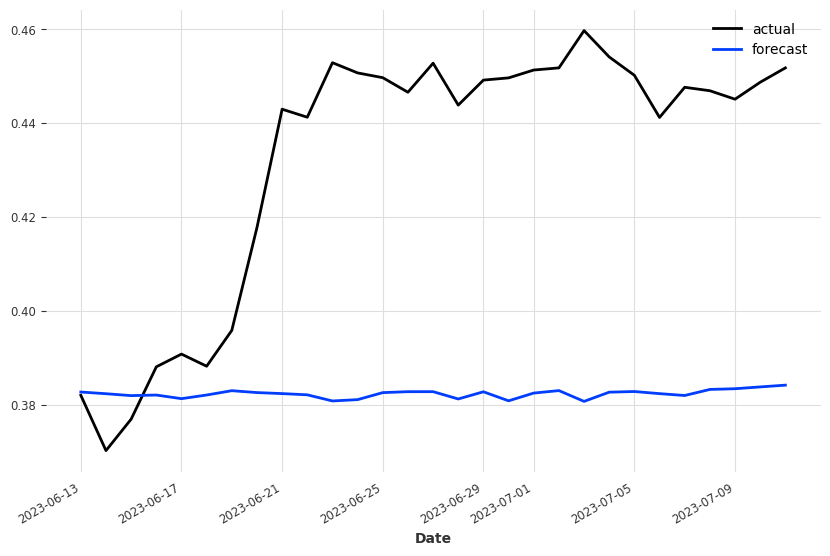

In [364]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
XGBRegressor_pred_scaled["BTC"].plot(label="forecast")

In [365]:
accuracy_metrics_dict["XGBRegressor with covs"] = { }
accuracy_metrics_dict["XGBRegressor with covs"]["mse"] = mse(XGBRegressor_pred, val)
accuracy_metrics_dict["XGBRegressor with covs"]["mape"] = mape(XGBRegressor_pred, val)
accuracy_metrics_dict["XGBRegressor with covs"]["smape"] = smape(XGBRegressor_pred, val)
accuracy_metrics_dict

{'NBEATSModel no covs': {'mse': 3643713.5804385156,
  'mape': 18.13694652030573,
  'smape': 18.141183550022046},
 'NBEATSModel with covs': {'mse': 10706150.302725244,
  'mape': 41.71088653861199,
  'smape': 28.827726366082857},
 'BayesianRidge with covs': {'mse': 3989469.8507875428,
  'mape': 18.287356301460285,
  'smape': 18.043553886020575},
 'LGBMRegressor with covs': {'mse': 2436176.0297599994,
  'mape': 12.31065925161899,
  'smape': 11.042207133417346},
 'XGBRegressor with covs': {'mse': 2985597.3512455076,
  'mape': 17.93906261176489,
  'smape': 15.451687776955541}}

# With neural networks

# BlockRNNModel

Explain 
    model="LSTM": Either a string specifying the RNN module type (“RNN”, “LSTM” or “GRU”), or a PyTorch module with the same specifications as darts.models.rnn_model._RNNModule.

    hidden_dim=20: Size for feature maps for each hidden RNN layer (hn),
    batch_size=8: Number of time series (input and output sequences) used in each training pass. Default: 32,
    n_epochs=8: Number of epochs over which to train the model. Default: 100,
    random_state=0:  Control the randomness of the weights initialization. Check this link for more details. Default: None,
    training_length=36: The length of both input (target and covariates) and output (target) time series used during training. Generally speaking, training_length should have a higher value than input_chunk_length because otherwise during training the RNN is never run for as many iterations as it will during inference. For more information on this parameter, please see darts.utils.data.ShiftedDataset,
    input_chunk_length=input_chunk_length: Number of past time steps that are fed to the forecasting module at prediction time.,
    force_reset=True: If set to True, any previously-existing model with the same name will be reset (all checkpoints will be discarded). Default: False,

This model supports future covariates; and it requires these covariates to extend far enough in the past and the future (it’s a so-called “dual covariates” model as the future covariates have to be provided both in the past and the future). The model will complain if the provided future_covariates series doesn’t have an appropriate time span.



In [366]:
from darts.models import RNNModel

RNNModel_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=10,
    random_state=0,
    training_length=36,
    input_chunk_length=input_chunk_length,
    force_reset=True,
)

RNNModel_model.fit(
    series=train_scaled,
    future_covariates=future_covs.astype("float32"),
    verbose=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/evagian/.pyenv/versions/3.9.16/envs/timeseries_forecasting_with_covariates/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.7 K 
4 | V             | Linear           | 105   
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=36, batch_size=8, n_epochs=10, random_state=0, input_chunk_length=180, force_reset=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

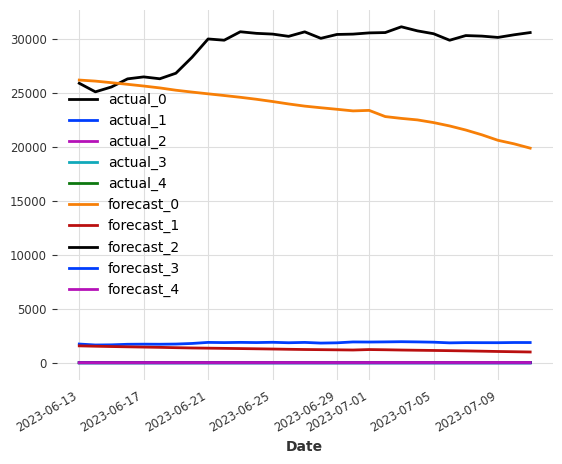

In [367]:
RNNModel_pred_scaled = RNNModel_model.predict(
    n=len(val), series=train_scaled, future_covariates=future_covs.astype("float32")
)
# scale back:
RNNModel_pred = scaler.inverse_transform(RNNModel_pred_scaled)

val.plot(label="actual")
RNNModel_pred.plot(label="forecast")
plt.legend()

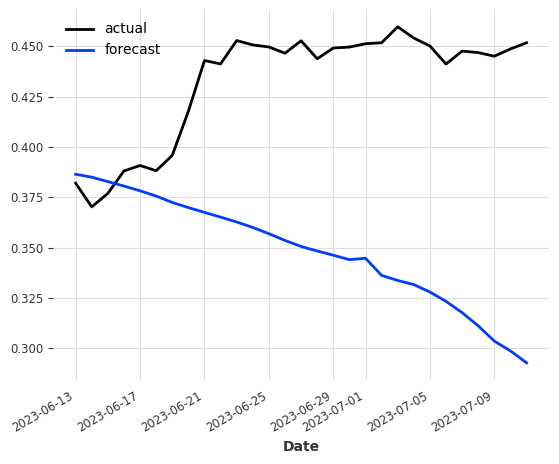

In [368]:
val_scaled["BTC"].plot(label="actual")
RNNModel_pred_scaled["BTC"].plot(label="forecast")
plt.legend()

In [369]:
accuracy_metrics_dict["RNNModel with covs"] = { }
accuracy_metrics_dict["RNNModel with covs"]["mse"] = mse(RNNModel_pred, val)
accuracy_metrics_dict["RNNModel with covs"]["mape"] = mape(RNNModel_pred, val)
accuracy_metrics_dict["RNNModel with covs"]["smape"] = smape(RNNModel_pred, val)
accuracy_metrics_dict

{'NBEATSModel no covs': {'mse': 3643713.5804385156,
  'mape': 18.13694652030573,
  'smape': 18.141183550022046},
 'NBEATSModel with covs': {'mse': 10706150.302725244,
  'mape': 41.71088653861199,
  'smape': 28.827726366082857},
 'BayesianRidge with covs': {'mse': 3989469.8507875428,
  'mape': 18.287356301460285,
  'smape': 18.043553886020575},
 'LGBMRegressor with covs': {'mse': 2436176.0297599994,
  'mape': 12.31065925161899,
  'smape': 11.042207133417346},
 'XGBRegressor with covs': {'mse': 2985597.3512455076,
  'mape': 17.93906261176489,
  'smape': 15.451687776955541},
 'RNNModel with covs': {'mse': 8770874.560567902,
  'mape': 33.41201878551287,
  'smape': 27.605919092819864}}

# BayesianRidge is still better

In [370]:
accuracy_metrics_df = pd.DataFrame.from_dict(accuracy_metrics_dict, orient='index').T
accuracy_metrics_df


,NBEATSModel no covs,NBEATSModel with covs,BayesianRidge with covs,LGBMRegressor with covs,XGBRegressor with covs,RNNModel with covs
mse,3.643714e+06,1.070615e+07,3.989470e+06,2.436176e+06,2.985597e+06,8.770875e+06
mape,1.813695e+01,4.171089e+01,1.828736e+01,1.231066e+01,1.793906e+01,3.341202e+01
smape,1.814118e+01,2.882773e+01,1.804355e+01,1.104221e+01,1.545169e+01,2.760592e+01


In [371]:
accuracy_metrics_df = accuracy_metrics_df.reset_index()
accuracy_metrics_df

,index,NBEATSModel no covs,NBEATSModel with covs,BayesianRidge with covs,LGBMRegressor with covs,XGBRegressor with covs,RNNModel with covs
0,mse,3.643714e+06,1.070615e+07,3.989470e+06,2.436176e+06,2.985597e+06,8.770875e+06
1,mape,1.813695e+01,4.171089e+01,1.828736e+01,1.231066e+01,1.793906e+01,3.341202e+01
2,smape,1.814118e+01,2.882773e+01,1.804355e+01,1.104221e+01,1.545169e+01,2.760592e+01


In [372]:

accuracy_metrics_df['best_model'] = accuracy_metrics_df.idxmin(axis=1, numeric_only=True)
accuracy_metrics_df = accuracy_metrics_df.rename(columns={"index": "metric"})
accuracy_metrics_df

,metric,NBEATSModel no covs,NBEATSModel with covs,BayesianRidge with covs,LGBMRegressor with covs,XGBRegressor with covs,RNNModel with covs,best_model
0,mse,3.643714e+06,1.070615e+07,3.989470e+06,2.436176e+06,2.985597e+06,8.770875e+06,LGBMRegressor with covs
1,mape,1.813695e+01,4.171089e+01,1.828736e+01,1.231066e+01,1.793906e+01,3.341202e+01,LGBMRegressor with covs
2,smape,1.814118e+01,2.882773e+01,1.804355e+01,1.104221e+01,1.545169e+01,2.760592e+01,LGBMRegressor with covs


<Axes: xlabel='n', ylabel='best_model'>

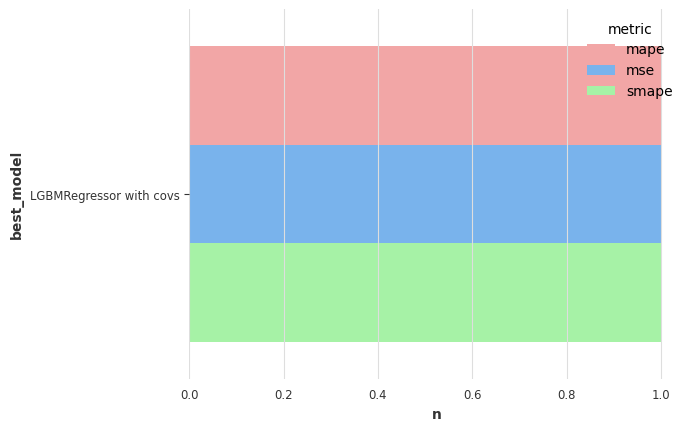

In [373]:
import seaborn as sns
# Choose the best model for each time series, metric, and cross validation window
accuracy_metrics_df['best_model'] = accuracy_metrics_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = accuracy_metrics_df.groupby(['metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sns.barplot(count_best_model, x='n', y='best_model', hue='metric', palette=colors)

# BayesianRidge with covs is the best model for all evaluation metrics

# Sources

* https://unit8co.github.io/darts/quickstart/00-quickstart.html